## Overview

Evaluation: 
- [ ] Testing  the  accuracy  of  the  trained  model  on  the  test  set  using  an  appropriate  evaluation 
measure, e.g., MAE for a regression problem. 
- [ ] Comparing the accuracy against the accuracy of a naive predictor. This is to test if it predicts better 
than random. 
- [ ] Performing a qualitative evaluation. Make a fine-grained comparison of predicted values against 
ground truth values, e.g., a scatterplot or heatmap for prediction of a continuous quantity (e.g., remaining  time  prediction)  or  a  detailed  confusion  matrix  for  outcome  prediction  (e.g.,  next   activity  prediction)  or  a  process  model  discovered  from  the  predicted  event  log  (e.g., next activity/suffix prediction).  

1. unknown declaration number 
2. how to deal with the path that can't calculate the time

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import pm4py
from datetime import datetime
import sklearn
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

In [4]:
event_log = pm4py.read_xes('InternationalDeclarations.xes') 

parsing log, completed traces ::   0%|          | 0/6449 [00:00<?, ?it/s]

In [5]:
agg_df = pd.read_csv('data/aggregation_enconding.csv')
last_state_df = pd.read_csv('data/last_state_enconding.csv')
agg_df["concept:name"] = last_state_df["concept:name"]
agg_df['case:TripDuration'] = pd.to_timedelta(agg_df['case:TripDuration']).astype('timedelta64[D]') # to number of days
agg_df['time:Remaining'] = pd.to_timedelta(agg_df['time:Remaining']).dt.total_seconds() # to total seconds
agg_df['time:relative'] = pd.to_timedelta(agg_df['time:relative']).dt.total_seconds() 
print(len(agg_df['case:id'].unique()))
agg_df

4009


,time:timestamp,case:Amount,case:Permit BudgetNumber,case:Permit OrganizationalEntity,case:Permit RequestedBudget,case:id,case:BudgetNumber,case:TripDuration,case:TripStartMonth,case:TripEndMonth,...,act_Permit SUBMITTED,act_Request Payment,act_Send Reminder,res_ADMINISTRATION,res_BUDGET OWNER,res_DIRECTOR,res_EMPLOYEE,res_SUPERVISOR,res_UNDEFINED,concept:name
0,2018-03-01 09:55:17+00:00,361.392240,budget 994,organizational unit 65460,1273.252058,declaration 1002,budget 146827,4.0,3.0,3,...,1,0,0,0,0,0,1,0,0,Permit SUBMITTED
1,2018-03-01 09:55:21+00:00,361.392240,budget 994,organizational unit 65460,1273.252058,declaration 1002,budget 146827,4.0,3.0,3,...,1,0,0,1,0,0,1,0,0,Permit APPROVED
2,2018-03-01 14:01:48+00:00,361.392240,budget 994,organizational unit 65460,1273.252058,declaration 1002,budget 146827,4.0,3.0,3,...,1,0,0,1,0,0,1,1,0,Permit FINAL_APPROVED
3,2018-03-27 14:15:02+00:00,361.392240,budget 994,organizational unit 65460,1273.252058,declaration 1002,budget 146827,4.0,3.0,3,...,1,0,0,1,0,0,2,1,0,Declaration SUBMITTED
4,2018-04-03 15:07:56+00:00,361.392240,budget 994,organizational unit 65460,1273.252058,declaration 1002,budget 146827,4.0,3.0,3,...,1,0,0,2,0,0,2,1,0,Declaration APPROVED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33245,2018-05-15 12:41:16+00:00,1539.687646,budget 9699,organizational unit 65469,666.621765,declaration 9955,budget 146805,2.0,5.0,5,...,1,0,0,1,1,0,2,1,0,Declaration SUBMITTED
33246,2018-05-15 12:41:24+00:00,1539.687646,budget 9699,organizational unit 65469,666.621765,declaration 9955,budget 146805,2.0,5.0,5,...,1,0,0,2,1,0,2,1,0,Declaration APPROVED
33247,2018-05-18 08:36:53+00:00,1539.687646,budget 9699,organizational unit 65469,666.621765,declaration 9955,budget 146805,2.0,5.0,5,...,1,0,0,2,2,0,2,1,0,Declaration APPROVED
33248,2018-05-22 08:53:22+00:00,1539.687646,budget 9699,organizational unit 65469,666.621765,declaration 9955,budget 146805,2.0,5.0,5,...,1,0,0,2,2,0,2,2,0,Declaration FINAL_APPROVED


In [6]:
df_answer = agg_df[["case:id", "concept:name", "time:Remaining", "time:relative"]]
df_answer

,case:id,concept:name,time:Remaining,time:relative
0,declaration 1002,Permit SUBMITTED,3389741.0,0.0
1,declaration 1002,Permit APPROVED,3389737.0,4.0
2,declaration 1002,Permit FINAL_APPROVED,3374950.0,14791.0
3,declaration 1002,Declaration SUBMITTED,1127756.0,2261985.0
4,declaration 1002,Declaration APPROVED,519782.0,2869959.0
...,...,...,...,...
33245,declaration 9955,Declaration SUBMITTED,787791.0,7271772.0
33246,declaration 9955,Declaration APPROVED,787783.0,7271780.0
33247,declaration 9955,Declaration APPROVED,543254.0,7516309.0
33248,declaration 9955,Declaration FINAL_APPROVED,196665.0,7862898.0


In [7]:
#Naive predictors
#Calculate the average time for cases of the same length
naive_predictors = pd.DataFrame(columns=['case:id','length','time'])
for i in list(agg_df.groupby('case:id')):
    df_temp = i[1]
    case_id = i[0]
    length = len(df_temp)
    time = df_temp.iloc[0]['time:Remaining']
    
    row = {'case:id': case_id, 'length': length, 'time': time}
    new_df = pd.DataFrame([row])
    naive_predictors = pd.concat([naive_predictors,new_df], axis=0, ignore_index=True)

#average of different type of process
naive_predictors_avg_time = naive_predictors.groupby('length', as_index=False)['time'].mean()


In [8]:
merge_df1 = pd.merge(df_answer, naive_predictors, on='case:id', how='inner')
merge_df2 = pd.merge(merge_df1, naive_predictors_avg_time, on='length', how='inner')
merge_df2["naive_predictors_answer"] = merge_df2["time_y"] - merge_df2["time:relative"] 
naive_predictors_answer = merge_df2[["case:id", "concept:name", "naive_predictors_answer"]]
#naive_predictors_answer.to_csv('gg.csv')
agg_df['naive_predictors_answer'] = naive_predictors_answer['naive_predictors_answer']
agg_df

,time:timestamp,case:Amount,case:Permit BudgetNumber,case:Permit OrganizationalEntity,case:Permit RequestedBudget,case:id,case:BudgetNumber,case:TripDuration,case:TripStartMonth,case:TripEndMonth,...,act_Request Payment,act_Send Reminder,res_ADMINISTRATION,res_BUDGET OWNER,res_DIRECTOR,res_EMPLOYEE,res_SUPERVISOR,res_UNDEFINED,concept:name,naive_predictors_answer
0,2018-03-01 09:55:17+00:00,361.392240,budget 994,organizational unit 65460,1273.252058,declaration 1002,budget 146827,4.0,3.0,3,...,0,0,0,0,0,1,0,0,Permit SUBMITTED,5.097881e+06
1,2018-03-01 09:55:21+00:00,361.392240,budget 994,organizational unit 65460,1273.252058,declaration 1002,budget 146827,4.0,3.0,3,...,0,0,1,0,0,1,0,0,Permit APPROVED,5.097877e+06
2,2018-03-01 14:01:48+00:00,361.392240,budget 994,organizational unit 65460,1273.252058,declaration 1002,budget 146827,4.0,3.0,3,...,0,0,1,0,0,1,1,0,Permit FINAL_APPROVED,5.083090e+06
3,2018-03-27 14:15:02+00:00,361.392240,budget 994,organizational unit 65460,1273.252058,declaration 1002,budget 146827,4.0,3.0,3,...,0,0,1,0,0,2,1,0,Declaration SUBMITTED,2.835896e+06
4,2018-04-03 15:07:56+00:00,361.392240,budget 994,organizational unit 65460,1273.252058,declaration 1002,budget 146827,4.0,3.0,3,...,0,0,2,0,0,2,1,0,Declaration APPROVED,2.227922e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33245,2018-05-15 12:41:16+00:00,1539.687646,budget 9699,organizational unit 65469,666.621765,declaration 9955,budget 146805,2.0,5.0,5,...,0,0,1,1,0,2,1,0,Declaration SUBMITTED,1.145118e+06
33246,2018-05-15 12:41:24+00:00,1539.687646,budget 9699,organizational unit 65469,666.621765,declaration 9955,budget 146805,2.0,5.0,5,...,0,0,2,1,0,2,1,0,Declaration APPROVED,1.143315e+06
33247,2018-05-18 08:36:53+00:00,1539.687646,budget 9699,organizational unit 65469,666.621765,declaration 9955,budget 146805,2.0,5.0,5,...,0,0,2,2,0,2,1,0,Declaration APPROVED,1.140968e+06
33248,2018-05-22 08:53:22+00:00,1539.687646,budget 9699,organizational unit 65469,666.621765,declaration 9955,budget 146805,2.0,5.0,5,...,0,0,2,2,0,2,2,0,Declaration FINAL_APPROVED,1.072816e+06


In [9]:
# Sort values by timestamp
agg_df.sort_values('time:timestamp', inplace=True)
# Make sure to drop the old indices values since the index is used to split temporally
agg_df.reset_index(drop=True, inplace=True)  

# Drop columns that are not suitable for random forest regressor
rf_input = agg_df.drop(columns=['time:timestamp', 'case:id', 'time:relative', 
                          'case:Permit BudgetNumber', 'case:Permit OrganizationalEntity',
                          'case:BudgetNumber', 'concept:name'])


#print(rf_input.dtypes)

# Split into 80% train and 20% test
train_set, test_set = np.split(rf_input, [int(.8 *len(rf_input))])

naive_predictors_train_set, naive_predictors_test_set = np.split(agg_df, [int(.8 *len(rf_input))])
naive_predictors_tesing_answer = naive_predictors_test_set['naive_predictors_answer']

X_train = train_set[rf_input.drop(columns=['time:Remaining']).columns]
y_train = train_set['time:Remaining']

X_test = test_set[rf_input.drop(columns=['time:Remaining']).columns]
y_test = test_set['time:Remaining']

print('train size: {} rows'.format(len(X_train)))
print('test size: {} rows'.format(len(X_test)))

train size: 26600 rows
test size: 6650 rows


In [10]:
#Final model
rf = RandomForestRegressor(bootstrap=False, max_depth=70, max_features='sqrt', min_samples_split=10, n_estimators=400).fit(X_train, y_train)

In [16]:
X_train

,case:Amount,case:Permit RequestedBudget,case:TripDuration,case:TripStartMonth,case:TripEndMonth,act_Declaration APPROVED,act_Declaration FINAL_APPROVED,act_Declaration REJECTED,act_Declaration SUBMITTED,act_Permit APPROVED,...,act_Permit SUBMITTED,act_Request Payment,act_Send Reminder,res_ADMINISTRATION,res_BUDGET OWNER,res_DIRECTOR,res_EMPLOYEE,res_SUPERVISOR,res_UNDEFINED,naive_predictors_answer
0,662.163043,694.336959,3.0,1.0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,7.795313e+06
1,662.163043,694.336959,3.0,1.0,1,0,0,0,0,1,...,1,0,0,1,0,0,1,0,0,7.795309e+06
2,160.987935,367.590155,1.0,2.0,2,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,-1.674378e+06
3,160.987935,367.590155,1.0,2.0,2,0,0,0,0,1,...,1,0,0,1,0,0,1,0,0,-1.945760e+06
4,372.239070,694.336959,2.0,5.0,5,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,6.531172e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26595,833.720314,1088.035084,4.0,9.0,9,2,1,0,1,1,...,1,1,0,2,1,0,2,2,1,6.531174e+06
26596,427.138254,4316.400573,35.0,8.0,9,2,1,0,1,2,...,1,0,0,2,2,0,2,2,0,4.868977e+06
26597,618.495017,459.789445,2.0,10.0,10,1,0,0,1,1,...,1,0,0,2,0,0,2,1,0,3.407646e+06
26598,63.681433,949.005415,4.0,8.0,8,1,0,0,1,1,...,1,0,1,2,0,0,2,1,1,5.555518e+06


In [59]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

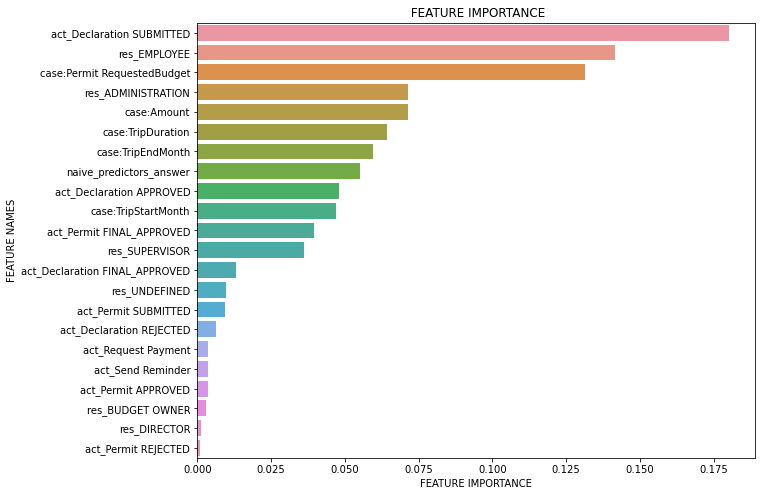

In [60]:
plot_feature_importance(rf.feature_importances_,X_train.columns,'RANDOM FOREST')

In [11]:
testing_data = rf.predict(X_test)

In [25]:
error = testing_data - y_test
error

26600    445469.783149
26601     52321.766486
26602   -100473.619203
26603     49792.566460
26604   -154362.360524
             ...      
33245    273030.286305
33246     27094.606523
33247    605429.850105
33248    261015.987036
33249    200678.409777
Name: time:Remaining, Length: 6650, dtype: float64

In [36]:
error.sort_values(ascending=True).to_csv('error_sort.csv')

In [44]:
#count how many case the error is smaller than 3 days
error[(error<259200)&(error>-259200)].count()

2585

In [45]:
#count how many case the error is smaller than 5 days
error[(error<432000)&(error>-432000)].count()

3519

In [47]:
error[error>0].count()

4815

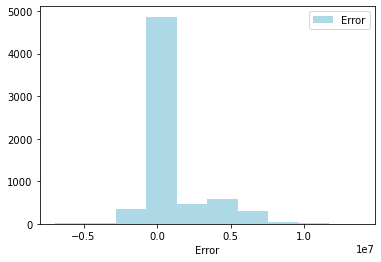

In [50]:
plt.hist(error, density=False, color = 'lightblue', cumulative = False, label = "Error")
plt.legend()
plt.xlabel('Error')
plt.show()

In [28]:
test_set['predict value'] = testing_data
test_set['error'] = error
test_set.to_csv('output.csv')

In [12]:
print(len(testing_data),len(y_test),len(naive_predictors_tesing_answer))
print('MAE, ground truth: ')
print(mae(testing_data, y_test))
print('MAE, naive predictors: ')
print(mae(testing_data, naive_predictors_tesing_answer))

6650 6650 6650
MAE, ground truth: 
1227882.5724655115
MAE, naive predictors: 
3961249.799752135


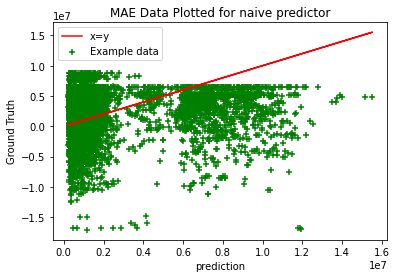

In [13]:
plt.scatter(testing_data, naive_predictors_tesing_answer, color = 'green', marker = '+', label = 'Example data')
plt.plot(testing_data, testing_data, color = 'red', label = 'x=y')
plt.title('MAE Data Plotted for naive predictor')
plt.xlabel('prediction')
plt.ylabel('Ground Truth')
plt.legend()
plt.show()

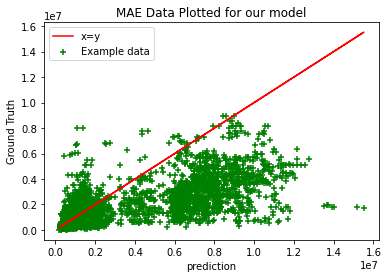

In [14]:
plt.scatter(testing_data, y_test, color = 'green', marker = '+', label = 'Example data')
plt.plot(testing_data, testing_data, color = 'red', label = 'x=y')
plt.title('MAE Data Plotted for our model')
plt.xlabel('prediction')
plt.ylabel('Ground Truth')
plt.legend()
plt.show()